In [40]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join

In [43]:
poses = pd.read_csv('../Task1/kitti/poses/00.txt', delimiter=' ', header=None)
ground_truth = np.zeros((len(poses), 3, 4))
for i in range(len(poses)):
    ground_truth[i] = np.array(poses.iloc[i]).reshape((3, 4))


In [44]:
left_img_files = os.listdir('kitti/00/image_0') 
img1_path = os.path.join('kitti/00/image_0', left_img_files[0])

# Load the image using OpenCV
img1 = cv2.imread(img1_path)

In [45]:
def SIFT_detector(img1, mask):
    gray_image = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) 

    sift = cv2.xfeatures2d.SIFT_create() 
    kp, des = sift.detectAndCompute(gray_image, mask) 
     
    return kp, des

def SURF_detector(img, mask):
    det = cv2.xfeatures2d.SURF_create()
    kp, des = det.detectAndCompute(img, mask)
    return kp, des

def ORB_detector(img, mask):
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  
    orb = cv2.ORB_create(nfeatures=200) 
    kp, des = orb.detectAndCompute(gray_image, mask) 

    return kp, des


In [46]:
def feature_detector(image, detector_type='sift',mask=None):
    if detector_type == 'sift':
        kp, des = SIFT_detector(image, mask)
    if detector_type == 'orb':
        kp, des = ORB_detector(image, mask)
    if detector_type == 'surf':
        kp, des = SURF_detector(image, mask)
    return kp, des

In [47]:
def match_features(des1, des2, matching='BF', detector_type='sift', sort=True, k=2):
 
    if matching == 'BF':
        if detector_type == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        elif detector_type == 'orb':
            matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k=k)
    elif matching == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(des1, des2, k=k)
    
    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    return matches

def filter_matches(matches, dist_threshold):

    filtered_matches = []
    for m,n in matches:
        ratio = m.distance/n.distance
        if ratio <= dist_threshold:
            filtered_matches.append(m)
    return filtered_matches

def convert_to_homogeneous_matrix(rmat,tvec):
    T_mat = np.eye(4,4)
    T_mat[:3,:3] = rmat
    T_mat[:3,3] = tvec.T
    return T_mat

In [29]:
def plot(trajectory,ground_truth):       
        fig = plt.figure(figsize=(12,8))
        ax = fig.add_subplot(111, projection='3d')

        ax.plot(trajectory[:, :, 3][:, 0], 
        trajectory[:, :, 3][:, 1], 
        trajectory[:, :, 3][:, 2], label='estimated', color='green')



        ax.plot(ground_truth[:,:,3][:,0], ground_truth[:,:,3][:,1], ground_truth[:,:,3][:,2])


        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        ax.legend
        ax.view_init(elev=-20, azim=270)

In [ ]:
def calculate_error(estimated, ground_truth):
    nframes_est = estimated.shape[0]-1
    se = np.sqrt((ground_truth[nframes_est, 0, 3] - estimated[:, 0, 3])**2 
                    + (ground_truth[nframes_est, 1, 3] - estimated[:, 1, 3])**2 
                    + (ground_truth[nframes_est, 2, 3] - estimated[:, 2, 3])**2)**2
    mse = se.mean()
    return mse

In [48]:
def run_vo_pipeline(left_img_files,K):
    prev_R = np.eye(3)
    prev_t = np.array([0, 0, 0])
    num_frames = len(left_img_files)
    trajectory = np.zeros((num_frames, 3, 4))
    curr_R = np.eye(3)
    curr_t = np.array([0, 0, 0]).reshape(3,1)
    T = np.eye(4)
    trajectory[0] = T[:3, :]

    for i in range(0, num_frames-1):        

        img1_path = os.path.join('kitti/00/image_0', left_img_files[i])
        img_1 = cv2.imread(img1_path)

        img2_path = os.path.join('kitti/00/image_0', left_img_files[i+1])
        img_2 = cv2.imread(img2_path)

        kp1,des1 = feature_detector(img_1)
        kp2,des2 = feature_detector(img_2)  
        match = match_features(des1,des2,k=2)
        filter_match = filter_matches(match,dist_threshold=0.5)   

        kp_1f = np.float32([kp1[m.queryIdx].pt for m in filter_match])
        kp_2f = np.float32([kp2[m.trainIdx].pt for m in filter_match])

        E, E_mask = cv2.findEssentialMat(kp_2f, kp_1f, K, cv2.RANSAC, 0.999, 1.0)

        if(E.shape != (3,3)):
            continue

        _, R, t, _ = cv2.recoverPose(E, kp_2f, kp_1f, K, mask=E_mask)

        R = R.transpose()
        t = np.matmul(R, t)

        

        if i == 0:
            curr_R = R
            curr_t = t
        else:
            curr_R = np.matmul(prev_R, R)
            curr_t = np.matmul(prev_R, t) + prev_t

        [tx, ty, tz] = [curr_t[0], curr_t[1], curr_t[2]]


        prev_R = curr_R
        prev_t = curr_t

        T_mat = convert_to_homogeneous_matrix(curr_R, curr_t)

        trajectory[i+1,  :, :] = T_mat[:3, :]

    return trajectory



In [49]:
k_int = np.array([[718.856  ,  0.   ,  607.1928],
 [  0.   ,  718.856 , 185.2157],
 [  0.    ,   0.     ,  1.    ]])


In [50]:
trajectory = run_vo_pipeline((left_img_files),k_int)


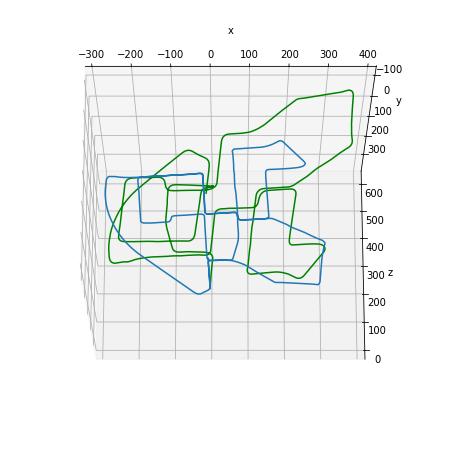

In [11]:
plot(trajectory,ground_truth)

In [51]:
calculate_error(trajectory, ground_truth)

115364.02999765353

Feature tracking visual odometery

In [70]:

kMinNumFeature = 3000
traj = np.zeros((600, 600, 3), dtype=np.uint8)
x_loc = []
z_loc = []
cur_R = None
cur_t = None
trajectory = np.zeros((len(left_img_files), 3, 4))
T = np.eye(4)
trajectory[0] = T[:3, :]



def featureTracking(image_ref, image_cur, px_ref):
    lk_params = dict(winSize  = (21, 21), 
                    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))
    kp2, st, err = cv2.calcOpticalFlowPyrLK(image_ref, image_cur, px_ref, None, **lk_params) 
    st = st.reshape(st.shape[0])
    kp1 = px_ref[st == 1]
    kp2 = kp2[st == 1]
    return kp1, kp2


def process_first_frames(first_frame, second_frame, k):
    det = cv2.FastFeatureDetector_create(threshold=20, nonmaxSuppression=True)
    kp1 = det.detect(first_frame)
    kp1 = np.array([x.pt for x in kp1], dtype=np.float32)

    kp1, kp2 = featureTracking(first_frame, second_frame, kp1)
    E, mask = cv2.findEssentialMat(kp2, kp1, k, method=cv2.RANSAC, prob=0.999, threshold=1.0)
    _, R, t, mask = cv2.recoverPose(E, kp2, kp1, k)
    kp1 = kp2
    return kp1, R, t

def feature_tracking_vo_pipeline(left_img_files, k):
    first_frame_path = os.path.join('kitti/00/image_0', left_img_files[0])
    first_frame = cv2.imread(first_frame_path, 0)
    second_frame_path = os.path.join('kitti/00/image_0', left_img_files[1])
    second_frame = cv2.imread(second_frame_path, 0)
    kp1, cur_R, cur_t = process_first_frames(first_frame, second_frame, k)
    last_frame = second_frame
    for i in range(len(left_img_files)-1):
        new_img_path =  os.path.join('kitti/00/image_0', left_img_files[i])
        new_frame = cv2.imread(new_img_path, 0)
        kp1, kp2 = featureTracking(last_frame, new_frame, kp1)
        E, mask = cv2.findEssentialMat(kp2, kp1, k, method=cv2.RANSAC, prob=0.999, threshold=1.0)
        _, R, t, mask = cv2.recoverPose(E, kp2, kp1, k)
    
        change = np.mean(np.abs(kp2 - kp1))
    
        if change > 5:
            cur_t = cur_t + 1* cur_R.dot(t)
            cur_R = R.dot(cur_R)
        if(kp1.shape[0] < kMinNumFeature):
            det = cv2.FastFeatureDetector_create(threshold=20, nonmaxSuppression=True)
            kp2 = det.detect(new_frame)
            kp2 = np.array([x.pt for x in kp2], dtype=np.float32)
        kp1 = kp2
        last_frame = new_frame
        if i > 2 :
            tvec= np.array([cur_t[0],cur_t[1],cur_t[2]]).reshape(3,1)
        else:
            tvec= np.array([0,0,0]).reshape(3,1)
        
        T_mat = convert_to_homogeneous_matrix(cur_R, cur_t)

        trajectory[i+1,  :, :] = T_mat[:3, :]  

    return trajectory


In [73]:
tracking_trajectory = feature_tracking_vo_pipeline(left_img_files,k_int)

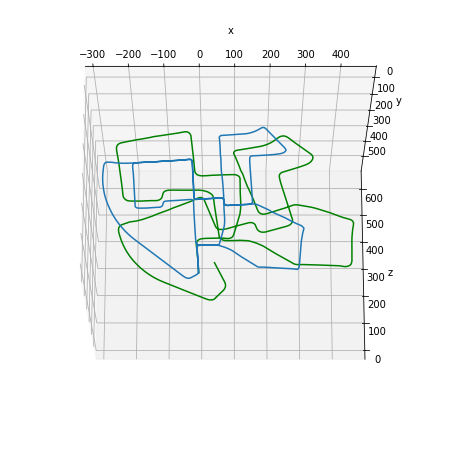

In [74]:
plot(tracking_trajectory,ground_truth)

In [75]:
calculate_error(tracking_trajectory,ground_truth)

220631.61007677906

Stereo Visual odometery

In [ ]:
def decompose_projection_matrix(p):
    
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = (t / t[3])[:3]
    
    return k, r, t


In [9]:
import cv2
import numpy as np

def compute_depth_map(img_left, img_right, k_left, t_left, t_right, matcher_name='sgbm'):

    sad_window = 6
    num_disparities = sad_window * 16
    block_size = 11
    
    if matcher_name == 'bm':
        matcher = cv2.StereoBM_create(numDisparities=num_disparities, blockSize=block_size)
    elif matcher_name == 'sgbm':
        matcher = cv2.StereoSGBM_create(
            numDisparities=num_disparities,
            minDisparity=0,
            blockSize=block_size,
            P1=8 * 3 * sad_window ** 2,
            P2=32 * 3 * sad_window ** 2,
            mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
        )

    disp_left = matcher.compute(img_left, img_right).astype(np.float32) / 16
    
    f = k_left[0][0]

    b = t_right[0] - t_left[0]
    
    disp_left[disp_left == 0.0] = 0.1
    disp_left[disp_left == -1.0] = 0.1
    
    depth_map = np.ones(disp_left.shape)
    depth_map = f * b / disp_left
    
    return depth_map


In [10]:
img_left_path = os.path.join('kitti/00/image_0', left_img_files[0])
img_left = cv2.imread(img_left_path,0)
right_img_files =  os.listdir('kitti/00/image_1') 
img_right = os.path.join('kitti/00/image_1', right_img_files[0])
img_right = cv2.imread(img_right,0)


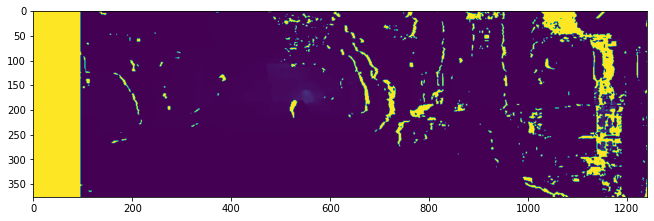

In [11]:
calib = pd.read_csv('kitti/' + 'calib.txt', delimiter=' ', header=None, index_col=0)
P0 = np.array(calib.loc['P0:']).reshape((3,4))
P1 = np.array(calib.loc['P1:']).reshape((3,4))
k_left, r_left, t_left = decompose_projection_matrix(P0)
k_right, r_right, t_right = decompose_projection_matrix(P1)


In [12]:
def stereo_motion_est(match, kp1, kp2, k, depth1, max_depth=3000):
    
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    
    image1_points = np.float32([kp1[m.queryIdx].pt for m in match])
    image2_points = np.float32([kp2[m.trainIdx].pt for m in match])

    cx = k[0, 2]
    cy = k[1, 2]
    fx = k[0, 0]
    fy = k[1, 1]
    object_points = np.zeros((0, 3))
    delete = []

    for i, (u, v) in enumerate(image1_points):
        z = depth1[int(v), int(u)]
        
        if z > max_depth:
            delete.append(i)
            continue
            
        x = z*(u-cx)/fx
        y = z*(v-cy)/fy
        object_points = np.vstack([object_points, np.array([x, y, z])])

    image1_points = np.delete(image1_points, delete, 0)
    image2_points = np.delete(image2_points, delete, 0)
    
    _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)
    
    rmat = cv2.Rodrigues(rvec)[0]


    
    return rmat, tvec, image1_points, image2_points

In [26]:
def stereo_vo_pipeline(left_img_files,right_img_files,P0,P1, detector = 'sift', matcher='FLANN',):
    num_frames = len(left_img_files)
    T_tot = np.eye(4)
    trajectory = np.zeros((num_frames, 3, 4))
    trajectory[0] = T_tot[:3, :]
    k_left, r_left, t_left = decompose_projection_matrix(P0)
    k_right, r_right, t_right = decompose_projection_matrix(P1)

    for i in range(num_frames-1):
        print(i)
        img_left_path = os.path.join('kitti/00/image_0', left_img_files[i]) 
        img_left = cv2.imread(img_left_path)
        img_right_path = os.path.join('kitti/00/image_1', right_img_files[i])
        img_right = cv2.imread(img_right_path)
        next_img_left = cv2.imread(os.path.join('kitti/00/image_0', left_img_files[i+1]))
        
        depth = compute_depth_map(img_left, img_right, k_left, t_left, t_right)
        kp1, des1 = feature_detector(img_left, detector_type=detector)
        kp2,des2 = feature_detector(next_img_left, detector_type= detector)

        matches= match_features(des1, des2, matching=matcher, detector_type=detector)
        filtered_matches = filter_matches(matches, dist_threshold=0.5 )

        R, t, img1_points, img2_points = stereo_motion_est(filtered_matches, kp1, kp2, k_left, depth1=depth)
        
        T_mat = convert_to_homogeneous_matrix(R, t)
        T_tot = T_tot.dot(np.linalg.inv(T_mat))

        trajectory[i+1, :, :] = T_tot[:3, :]

    return trajectory
        


In [ ]:
stereo_trajectory = stereo_vo_pipeline(left_img_files,right_img_files, P0, P1)

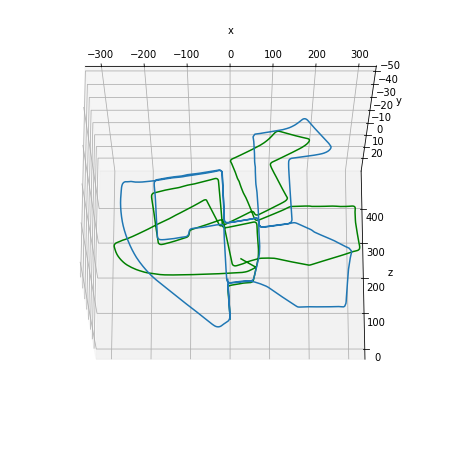

In [52]:
plot(stereo_trajectory,ground_truth)

In [38]:
calculate_error(stereo_trajectory,ground_truth)

53544.89697485196